In [ ]:
dimport matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import tensorflow as tf
import zipfile

from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#with zipfile.ZipFile("/content/drive/MyDrive/player_pictures/x.zip", 'r') as zip_ref:
#    zip_ref.extractall("/content/drive/MyDrive/player_pictures")

data_dir = pathlib.Path('/content/drive/MyDrive/player_pictures/')

In [ ]:
batch_size = 64
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = 'training',
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 7666 files belonging to 5 classes.
Using 6133 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = 'validation',
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 7666 files belonging to 5 classes.
Using 1533 files for validation.


In [ ]:
# If you don't want to run the code above,
# you can just use the following:
class_names = ['baseball', 'basketball', 'cricket', 'football', 'hockey']
#class_names = train_ds.class_names
print(class_names)

['baseball', 'basketball', 'cricket', 'football', 'hockey']


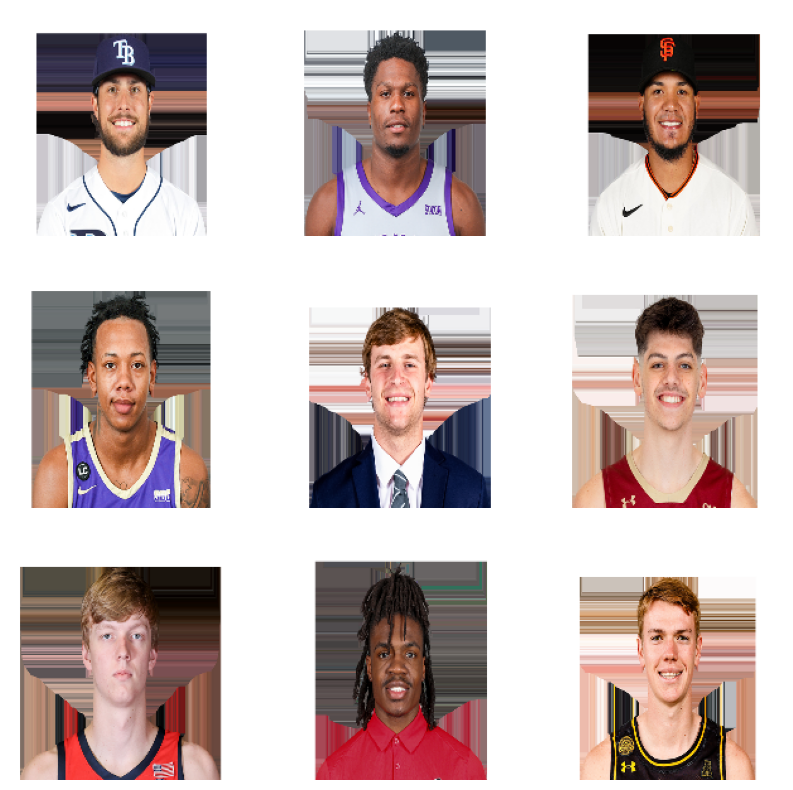

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
num_classes = len(class_names)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

model = Sequential([
  keras.Input(shape = (img_height, img_width, 3)),
  data_augmentation,
  layers.Rescaling(1./255),
  layers.CenterCrop(80, 80),
  layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation = 'relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [ ]:
epochs=5
history = model.fit(
  x = train_ds,
  validation_data = val_ds,
  batch_size = 64,
  epochs = epochs
)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 578s 1s/step - accuracy: 0.6581 - loss: 0.9851 - val_accuracy: 0.8343 - val_loss: 0.4472
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8439 - loss: 0.4195 - val_accuracy: 0.8735 - val_loss: 0.3366
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8780 - loss: 0.3298 - val_accuracy: 0.8689 - val_loss: 0.4191
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8695 - loss: 0.3491 - val_accuracy: 0.8878 - val_loss: 0.2988
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8947 - loss: 0.2899 - val_accuracy: 0.8819 - val_loss: 0.3247


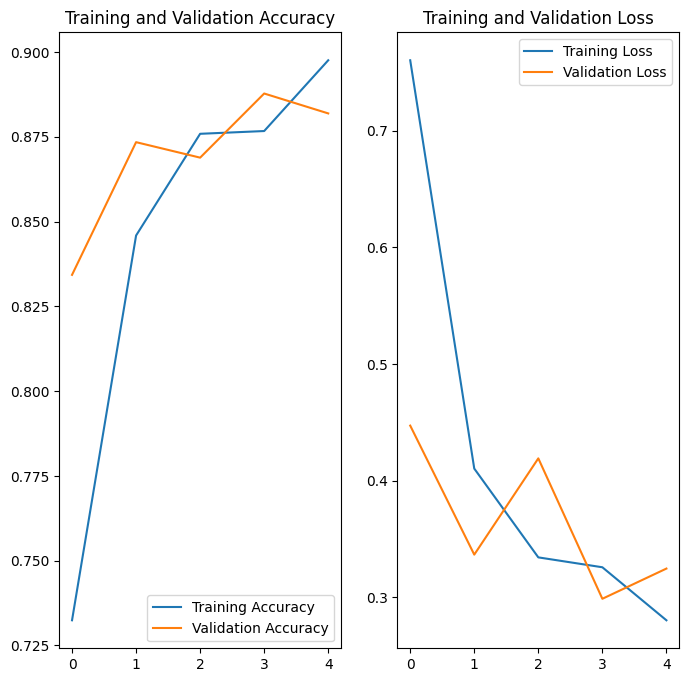

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/image_model.keras')

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/image_model.keras")

In [ ]:
seth_url = "https://directory.mendoza.nd.edu/media/1153/sberry5.jpg?anchor=center&mode=crop&width=250&height=250&rnd=131916914060000000"
seth_path = tf.keras.utils.get_file('sberry5', origin = seth_url)

img = keras.preprocessing.image.load_img(
    seth_path, target_size = (img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
This image most likely belongs to cricket with a 99.43 percent confidence.


In [ ]:
other_url = "https://www3.nd.edu/~sberry5/data/students/.jpg"
other_path = tf.keras.utils.get_file('', origin = other_url)

img = keras.preprocessing.image.load_img(
    other_path, target_size = (img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


39500/39500 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
This image most likely belongs to basketball with a 89.67 percent confidence.


In [ ]:
image_path = "/content/drive/MyDrive/troy_p.jpg"

img = keras.preprocessing.image.load_img(
    image_path,
    target_size = (img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)


In [ ]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
This image most likely belongs to basketball with a 51.22 percent confidence.


In [ ]:
! pip install imageAI
! pip install opencv-python

     |████████████████████████████████| 160 kB 5.6 MB/s 
     |████████████████████████████████| 2.1 MB 33.1 MB/s 
ERROR: Operation cancelled by user


In [ ]:
import os

from imageai.Detection import ObjectDetection

os.chdir("/content/drive/MyDrive/cv_models")

detector = ObjectDetection()

# You can find all of the model object at the following site:
# https://github.com/OlafenwaMoses/ImageAI/blob/master/imageai/Classification/README.md

# Your goal is find some images to play with!

model_path = "./models/yolo-tiny.h5"
#model_path = "./models/yolo.h5"
#model_path = "./models/resnet50_coco_best_v2.1.0.h5" # Can be weird!
input_path = "./input/stroke_sim.jpg"
#input_path = "./input/people2.jpg"
output_path = "./output/stroke_sim_label.jpg"

detector.setModelTypeAsTinyYOLOv3()
#detector.setModelTypeAsYOLOv3()
#detector.setModelTypeAsRetinaNet() # Can be weird!
detector.setModelPath(model_path)
detector.loadModel()
detection = detector.detectObjectsFromImage(input_image=input_path, output_image_path=output_path)

for eachItem in detection:
    print(eachItem["name"] , " : ", eachItem["percentage_probability"])

ModuleNotFoundError: ignored